In [1]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [2]:
import glob
import os

# Set the current working directory to where the notebook is located
notebook_dir = os.path.abspath('')
os.chdir(notebook_dir)

# Define paths to the dataset
dataset_dir = os.path.join(notebook_dir, 'building_dataset')

# If the dataset folder contains 'train' and 'test' subfolders
train_x = sorted(glob.glob(os.path.join(dataset_dir, 'train', '*_image.tif')))
train_y = sorted(glob.glob(os.path.join(dataset_dir, 'train', '*_label.tif')))
test_x = sorted(glob.glob(os.path.join(dataset_dir, 'test', '*_image.tif')))
test_y = sorted(glob.glob(os.path.join(dataset_dir, 'test', '*_label.tif')))

print(len(train_x), len(test_x))


70 30


## Data preprocessing

In [3]:
# converting training image to numpy array
train_xx = np.zeros((70, 128, 128, 3))
train_yy = np.zeros((70, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask

In [4]:
# converting training image to numpy array
test_xx = np.zeros((30, 128, 128, 3))
test_yy = np.zeros((30, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):

  img = Image.open(img)
  np_img = np.array(img)
  test_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask

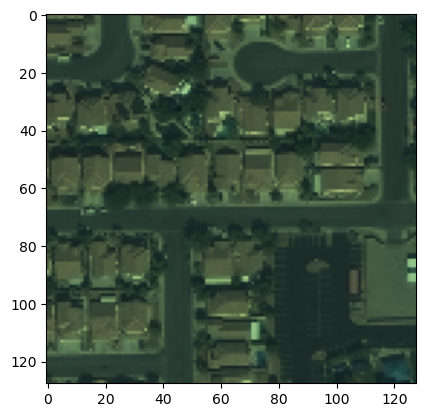

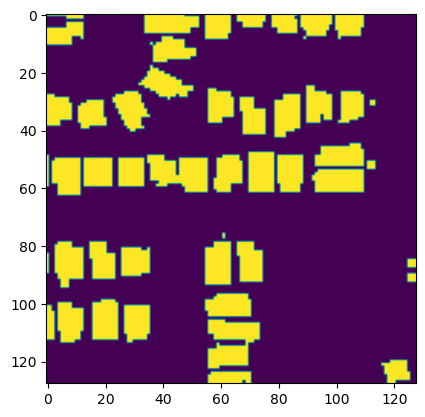

In [5]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(train_xx[20, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[20, :, :, 0].astype('uint8'))
plt.show()

## Save to numpy format

In [6]:
train_xx.shape

(70, 128, 128, 3)

In [7]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

## U-Net model development
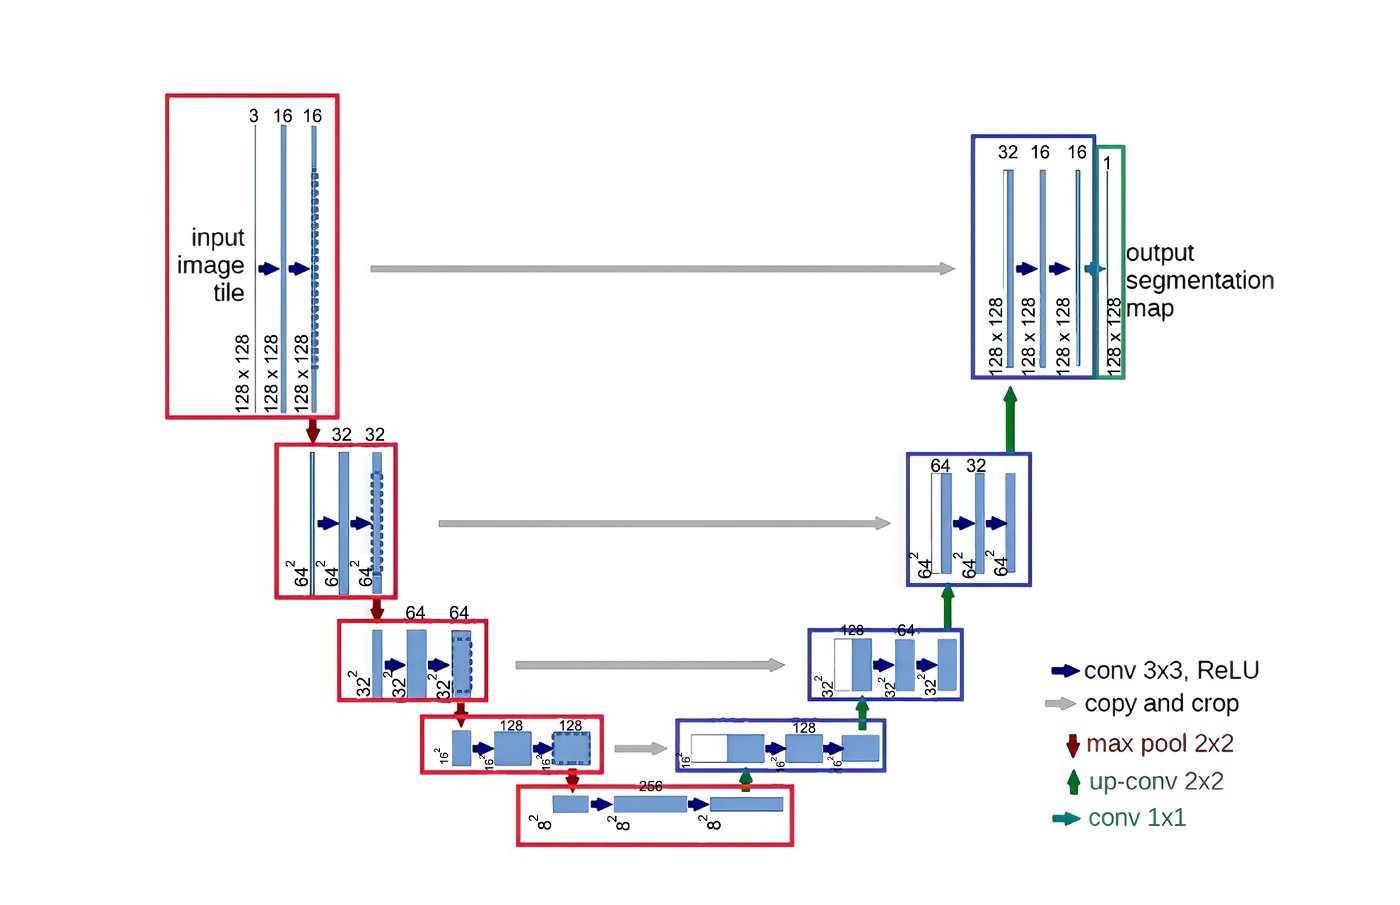


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# Input
x_in = Input(shape=(128, 128, 3))

# Encoder
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_in)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(x_temp)

# Decoder
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

# Output layer
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = BatchNormalization()(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = BatchNormalization()(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)

# Model compilation
model = Model(inputs=x_in, outputs=x_out)

# Compile the model with Nadam optimizer, mean squared error loss, and accuracy as a metric
optimizer = Nadam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Print model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

C:\Softwares\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\nadam.py:86: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/1000
9/9 [==============================] - 11s 261ms/step - loss: 3.2429 - accuracy: 0.6529 - val_loss: 3.3422 - val_accuracy: 0.2316
Epoch 2/1000
9/9 [==============================] - 1s 58ms/step - loss: 2.4836 - accuracy: 0.7725 - val_loss: 2.6622 - val_accuracy: 0.2316
Epoch 3/1000
9/9 [==============================] - 1s 63ms/step - loss: 1.8339 - accuracy: 0.8249 - val_loss: 2.1319 - val_accuracy: 0.2318
Epoch 4/1000
9/9 [==============================] - 1s 58ms/step - loss: 1.3281 - accuracy: 0.8617 - val_loss: 1.5560 - val_accuracy: 0.3140
Epoch 5/1000
9/9 [==============================] - 1s 59ms/step - loss: 0.9698 - accuracy: 0.8753 - val_loss: 1.0111 - val_accuracy: 0.6387
Epoch 6/1000
9/9 [==============================] - 1s 58ms/step - loss: 0.7194 - accuracy: 0.8810 - val_loss: 0.7649 - val_accuracy: 0.6886
Epoch 7/1000
9/9 [==============================] - 1s 60ms/step - loss: 0.5408 - accuracy: 0.8875 - val_loss: 0.5371 - val_accuracy: 0.8139
Epoch 8/100

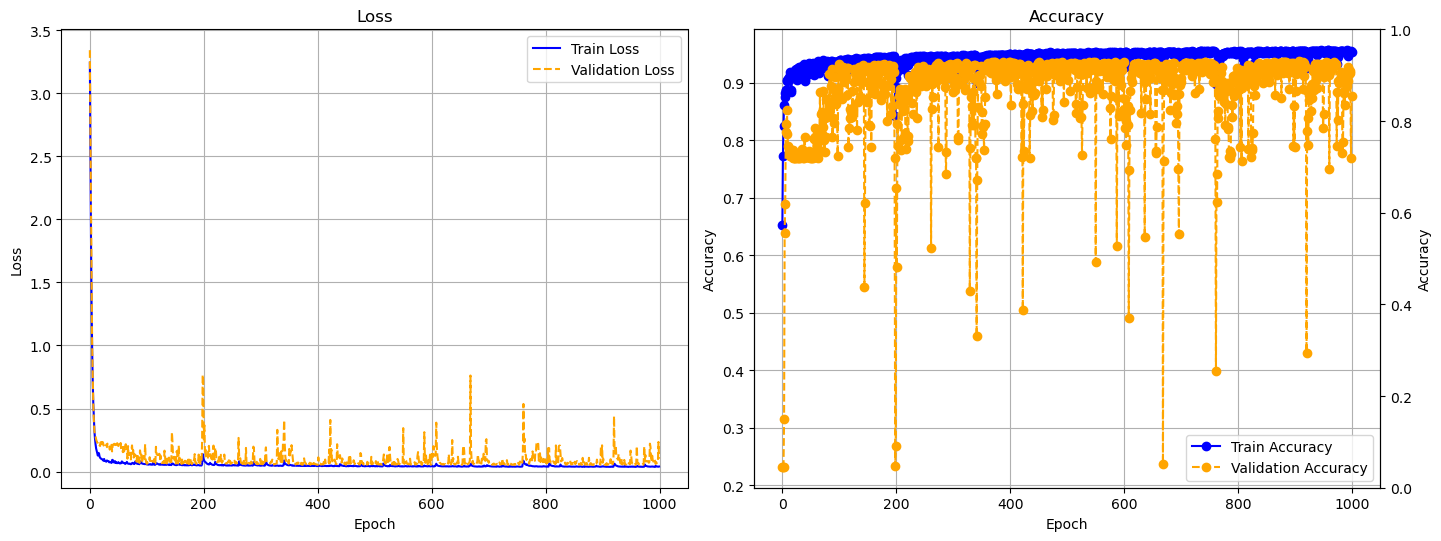

In [9]:
import matplotlib.pyplot as plt

history = model.fit(train_xx, train_yy, 
                    validation_data=(test_xx, test_yy), 
                    epochs=1000, 
                    batch_size=8, 
                    verbose=1)


def plot_metrics(history):
    # Increase the size of the plots
    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', linestyle='-', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', color='orange')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add grid lines

    # Plot accuracy if available
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='-', color='blue', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--', color='orange', marker='o')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.grid(True)  # Add grid lines
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent overlapping of labels

        # Add secondary y-axis for accuracy plot
        ax2 = plt.gca().twinx()
        ax2.set_ylabel('Accuracy')
        ax2.set_ylim(0, 1)

    else:
        plt.tight_layout()
    
    plt.show()

# Call the function passing the training history object
plot_metrics(history)


# Prediction

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions(pred, actual, indices=None, threshold=0.5, save_path=None):
    """
    Plot predicted and actual values.

    Parameters:
    - pred: Predicted values.
    - actual: Actual values.
    - indices: List of indices to visualize (default is None, which plots randomly selected indices).
    - threshold: Threshold for binarizing predictions (default is 0.5).
    - save_path: Path to save the plots as images (default is None, which does not save).
    """
    if indices is None:
        indices = np.random.choice(pred.shape[0], size=min(3, pred.shape[0]), replace=False)

    for idx in indices:
        # Binarize predictions using threshold
        pred_bin = (pred[idx] > threshold).astype(np.uint8)

        # Create figure and subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Plot predicted values
        im_pred = axs[0].imshow(pred_bin[:, :, 0], cmap='gray')
        axs[0].set_title(f'Predicted (Sample {idx})')
        axs[0].axis('off')
        plt.colorbar(im_pred, ax=axs[0], fraction=0.046, pad=0.04)

        # Plot actual values
        im_actual = axs[1].imshow(actual[idx, :, :, 0], cmap='gray')
        axs[1].set_title(f'Actual (Sample {idx})')
        axs[1].axis('off')
        plt.colorbar(im_actual, ax=axs[1], fraction=0.046, pad=0.04)

        # Save plot if save_path is provided
        if save_path is not None:
            plt.savefig(f'{save_path}/sample_{idx}.png')
            plt.close()
        else:
            plt.show()

# Example usage:
plot_predictions(pred_test, test_yy, indices=[0, 1, 2], threshold=threshold, save_path=None)


NameError: name 'pred_test' is not defined

## Convert numpy array to image

In [ ]:
from PIL import Image
import os
def convert_numpy_array_to_img(in_npy, out_folder, channel=3):
    n = in_npy.shape[0]
    for i in range(n):
        if channel==3:
            image = Image.fromarray(in_npy[i].astype('uint8'))
            image.save(os.path.join(out_folder, f"{i}_image.tif"))

        else:
            image = Image.fromarray(in_npy[i, :, :, 0])
            image.save(os.path.join(out_folder, f"{i}_label.tif"))

In [ ]:
import os
import cv2

def convert_numpy_array_to_img(array, folder, channel=3):
    """
    Convert numpy array to image and save it in the specified folder.

    Parameters:
    - array: Numpy array representing the image data.
    - folder: Folder path where the image will be saved.
    - channel: Number of channels in the image (default is 3 for RGB).

    """
    # Create folder if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    for i in range(array.shape[0]):
        # Construct file path
        file_path = os.path.join(folder, f'image_{i}.png')

        # Convert numpy array to image
        if channel == 1:
            img = array[i, :, :, 0]
        else:
            img = array[i]
        
        # Scale pixel values to 0-255
        img = img * 255.0
        img = img.astype('uint8')

        # Save image
        cv2.imwrite(file_path, img)

# Convert numpy arrays to images and save them
convert_numpy_array_to_img(x_train, 'train')
convert_numpy_array_to_img(y_train, 'train', channel=1)

convert_numpy_array_to_img(x_test, 'test')
convert_numpy_array_to_img(y_test, 'test', channel=1)
